In [3]:
import subprocess
import sys
import os

# imports a package if it exists and installs it if it doesn't
def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[package] = __import__(package)

list_of_packages = ["pandas","matplotlib","seaborn"]
for package in list_of_packages:
    install_and_import(package)

Packages needed for data cleaning and visualisation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Data Processing

In [5]:
def clean_dataframe(input_df):
    df_clean = input_df.copy()
    # Split 'storey_range' into two columns
    df_clean[['min_storey', 'max_storey']] = df_clean['storey_range'].str.split(' TO ', expand=True)
    # Convert the new columns to numeric values
    df_clean['min_storey'] = pd.to_numeric(df_clean['min_storey'], errors='coerce')
    df_clean['max_storey'] = pd.to_numeric(df_clean['max_storey'], errors='coerce')
    df_clean['flat_type'] = df_clean['flat_type'].astype('category')
    df_clean['flat_model'] = df_clean['flat_model'].astype('category')
    # more efficient than storing them as strings
    df_clean['yyyy'] = pd.to_datetime(df_clean['month']).dt.strftime('%Y').astype(int)
    df_clean['mm'] = pd.to_datetime(df_clean['month']).dt.strftime('%m').astype(int)
    df_clean = df_clean[['yyyy','mm','month','town','flat_type','block','street_name','floor_area_sqm','flat_model','lease_commence_date','remaining_lease','resale_price','min_storey','max_storey']]
    # display(df_clean)
    # print("old dtypes:")
    # display(input_df.dtypes)
    # print("new dtypes:")
    # display(df_clean.dtypes)
    # Check for missing values
    print("Checking for missing values")
    missing_values = df_clean.isnull().sum()
    display(missing_values)
    return df_clean

def add_features(input_df, dir_path):
    df_clean = input_df.copy()
    # add 'price_per_sqm' column
    df_clean['price_per_sqm'] = df_clean['resale_price'] / df_clean['floor_area_sqm']
    # proxies for density in older areas to see how older or newer buildings impact price per sqm.
    df_clean['transaction_density'] = df_clean.groupby(['town', 'yyyy', 'mm'])['resale_price'].transform('count')
    # Average flat size per town
    df_clean['avg_flat_size'] = df_clean.groupby('town')['floor_area_sqm'].transform('mean')
    df_clean['building_age'] = df_clean['yyyy'] - df_clean['lease_commence_date']
    # feature used to check whether storey ranges correlate with a denser residential environment
    df_clean['avg_storey'] = (df_clean['min_storey'] + df_clean['max_storey']) // 2
    # Average price per sqm per town
    df_clean['avg_price_per_sqm_town'] = df_clean.groupby('town')['price_per_sqm'].transform('mean')
    # rolling average of price per sqm 
    for i in range(3,7,3):
        df_clean[f'rolling_{i}_month_avg_price_per_sqm'] = df_clean.groupby('town')['price_per_sqm'].transform(lambda x: x.rolling(window=i).mean()).fillna(0)
    # display(df_clean)
    if os.path.isdir(dir_path):
        df_clean.to_csv(f'{dir_path}\processed\processed_resale_flat_prices.csv', index=False)
    return df_clean


Data visualisation

In [19]:
def plot_top_n_towns_based_on_average_price(input_df, directory, n=5):
    df_clean = input_df.copy()
    top_towns = df_clean.groupby('town')['price_per_sqm'].mean().nlargest(n).index
    filtered_data = df_clean[df_clean['town'].isin(top_towns)]
    for i in range(3,7,3):
        plt.figure(figsize=(14, 7))
        # Plot rolling average price per sqm over time for different towns
        sns.lineplot(data=filtered_data, x='month', y=f'rolling_{i}_month_avg_price_per_sqm', hue='town', alpha=0.8)
        plt.title('Price per Square Meter Over Time by Town', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(f'Rolling {i} month avg Price per Square Meter (SGD)', fontsize=12)
        plt.legend(title='Town', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        file_path = os.path.join(directory, f'rolling_{i}_month_avg_price_per_square_meter_by_town_top_{n}.jpg')
        plt.savefig(file_path, format='jpg')
        plt.show()
        
        
def plot_transaction_trends_over_time(input_df, directory, n=5):
    df_clean = input_df.copy()
    file_path = os.path.join(directory, f'Number_of_Transactions_Over_Time_by_Town_Top_{n}.jpg')
    # 'transaction_density' will repeat for each row in the same month and town
    transaction_data = df_clean[['town', 'month', 'transaction_density']].drop_duplicates()
    top_towns = transaction_data.groupby('town')['transaction_density'].mean().nlargest(n).index
    filtered_data = transaction_data[transaction_data['town'].isin(top_towns)]
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=filtered_data, x='month', y='transaction_density', hue='town', marker='o')
    plt.title('Number of Transactions Over Time by Town', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Transactions', fontsize=12)
    plt.legend(title='Town', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path, format='jpg')
    plt.show()

Checking for missing values


yyyy                   0
mm                     0
month                  0
town                   0
flat_type              0
block                  0
street_name            0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
min_storey             0
max_storey             0
dtype: int64

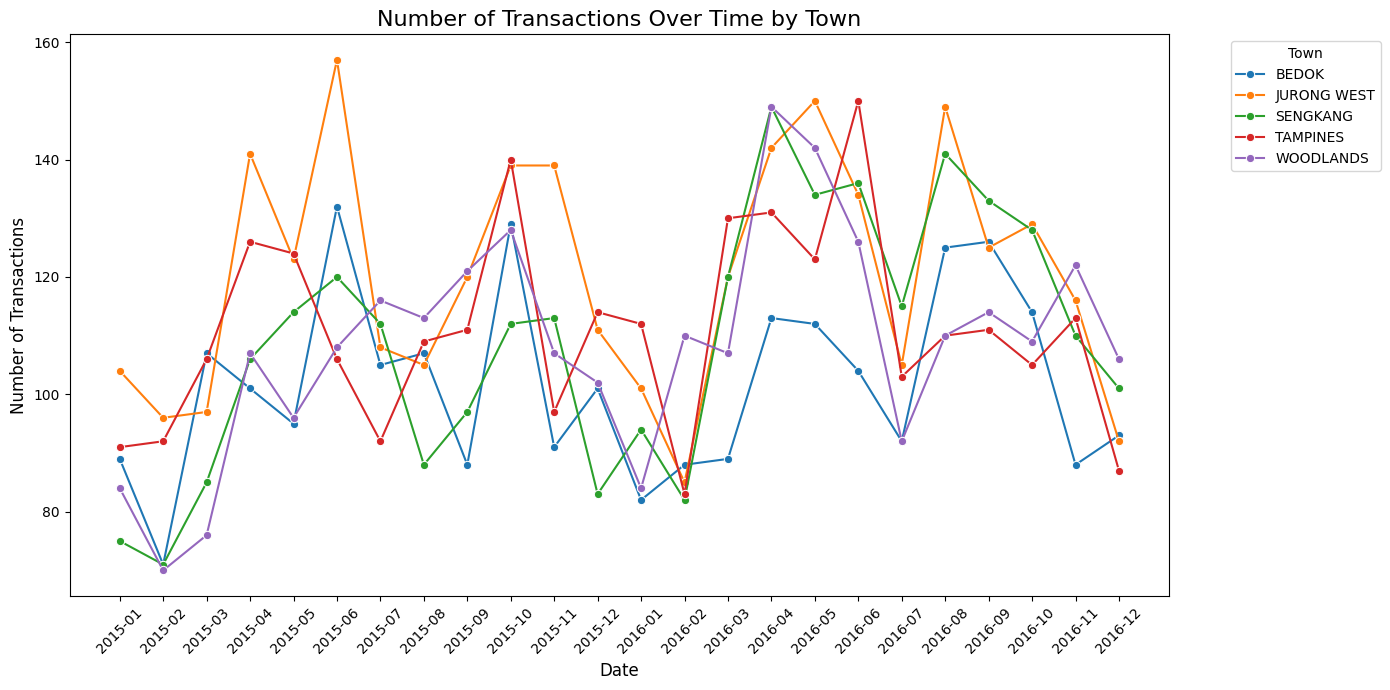

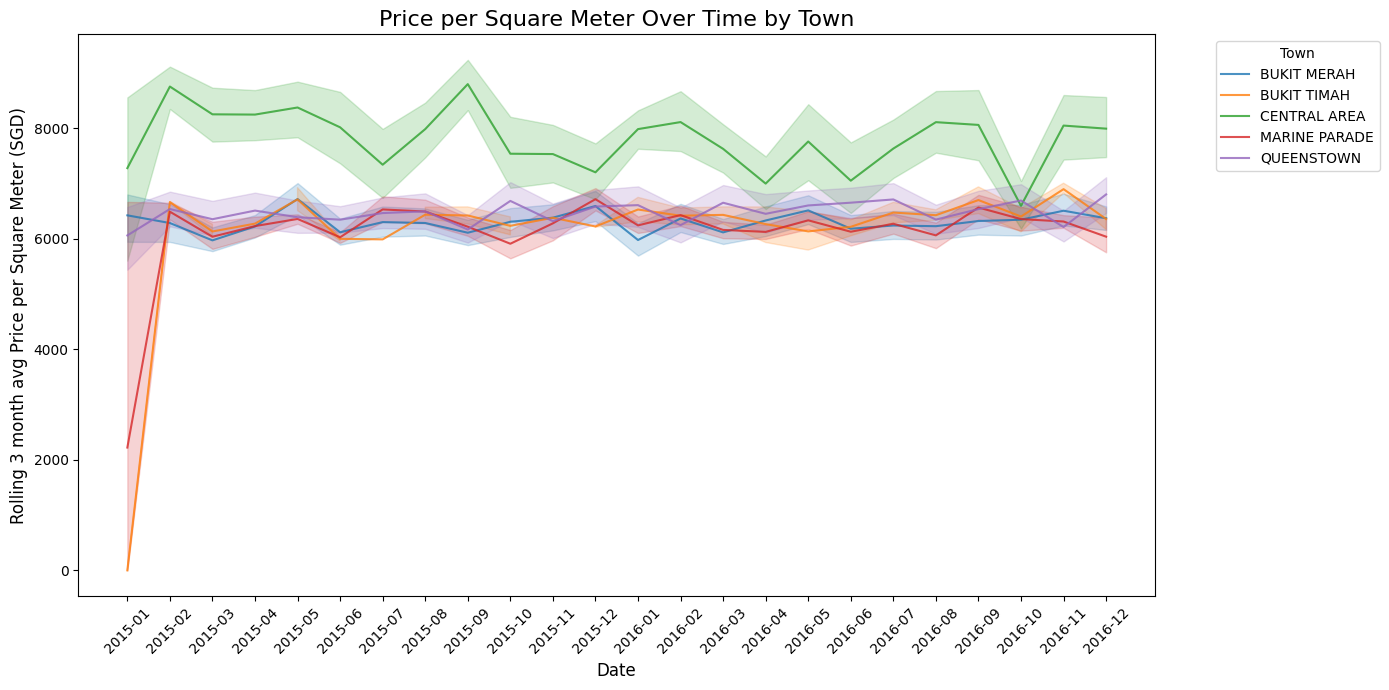

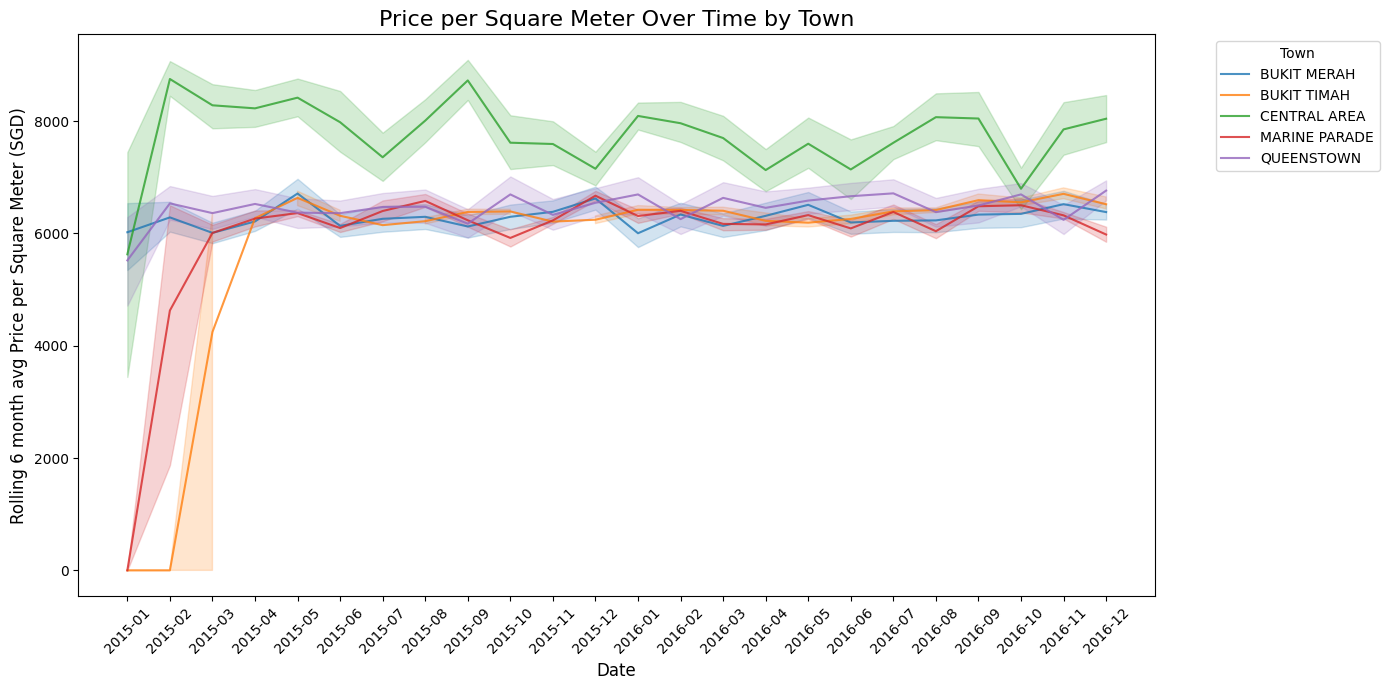

In [20]:
directory = r'C:\Users\study\OneDrive\Desktop\HDB-statistics\data'
csv_loc = f"{directory}\\raw\\ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016 (1).csv"
df = pd.read_csv(csv_loc)
clean_df = clean_dataframe(df)
processed_df = add_features(clean_df, directory)
plot_transaction_trends_over_time(processed_df, directory)
plot_top_n_towns_based_on_average_price(processed_df, directory)

## Insight 1: Price Trends

- The **Central Area** consistently has the highest price per square meter, indicating that properties here are highly desirable and maintain a premium value.
- In contrast, towns like **Bukit Merah**, **Queenstown**, and **Marine Parade** show more stable price trends over time. While they experience minor fluctuations, their prices remain in a consistent range, reflecting steady demand in these areas.

## Insight 2: Transaction Volume and Demand

- **Jurong West** and **Sengkang** have higher transaction volumes, suggesting either greater demand or more properties available in these towns.
- Peaks in transactions occur around **March-April** and **October-November**, hinting at possible **seasonality** in the real estate market. This suggests that people are more active in buying or selling during these periods.
- Towns like **Jurong West**, **Sengkang**, and **Tampines** show more volatility in transaction numbers, indicating fluctuations in demand or property availability. Meanwhile, **Bedok** and **Woodlands** exhibit more consistent transaction volumes, pointing to more stable market activity in these areas.
